# BareBonesML Part 9: The Vision Transformer (ViT)

Welcome to Phase 2 of BareBonesML! Having built our core components from scratch, we now shift our focus to implementing modern architectures in PyTorch. Our goal is no longer to build the framework, but to deeply understand the architectures themselves.

We begin with the **Vision Transformer (ViT)**, a model that revolutionized computer vision by demonstrating that the Transformer architecture, originally designed for Natural Language Processing (NLP), could achieve state-of-the-art results in image recognition.

The core insight of the paper ["An Image is Worth 16x16 Words"](https://arxiv.org/abs/2010.11929) is surprisingly simple: **what if we treat an image as a sequence of patches, just like a sentence is a sequence of words?**

![ViT Diagram](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F98b3af0b-a5ee-4184-b0ba-72cb0ce70d0b_1600x284.png)
Credit: [Sean Trott's VLMs post](https://seantrott.substack.com/p/vision-language-models-vlms-explained)

In this post, we will:
1.  Walk through the implementation of each ViT component from our library file.
2.  Explain how an image is deconstructed into a sequence of patch embeddings.
3.  Detail the structure of the Transformer Encoder and its sub-layers.
4.  Run a live demonstration, training a small ViT on the CIFAR-10 dataset and visualizing its attention mechanism.

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math

import sys
sys.path.append('../') 

# Import the ViT model from our library file
from pytorch_implementations.vit import ViTForClassfication

# Device Configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

print("Setup complete.")

Using MPS device.
Setup complete.


## Part 1: From Pixels to a Sequence - The ViT Embedding Layer

The first challenge in adapting Transformers for vision is converting a 2D grid of pixels into the 1D sequence of vectors that a Transformer expects. The ViT's `Embeddings` layer accomplishes this through a three-step process.

### Step 1.1: Patching and Projection (`PatchEmbeddings`)

The image is first split into fixed-size, non-overlapping patches. This is efficiently done using a `Conv2d` layer where the kernel size and stride are equal to the patch size. This layer processes each patch independently and performs a linear projection, mapping it to a vector of `hidden_size`.

Here is the full implementation from our library:

```python
# from pytorch_implementations/vit.py
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x
```

### Step 1.2: Adding the [CLS] Token and Positional Information

The sequence of patch embeddings now captures the content of the image, but it's missing two crucial pieces of information:

1.  **A Global Representation (`[CLS]` Token):** A special, learnable vector is prepended to the sequence. The Transformer will use the final output corresponding to this token as the aggregate representation of the entire image for classification.
2.  **Positional Information:** Since the attention mechanism is permutation-invariant, we must add learnable positional embeddings to inform the model about the original location of each patch.

Our `Embeddings` class combines these steps into a single module.

```python
# from pytorch_implementations/vit.py
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        x = torch.cat((cls_tokens, x), dim=1)
        # Add positional embeddings
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x
```
With this, the image preprocessing is complete. We now have a sequence of embeddings ready to be fed into the standard Transformer Encoder.

## Part 2: The Heart of ViT - The Transformer Encoder

Now that we have a sequence of embeddings, we can pass it to the heart of the model: the Transformer Encoder. The encoder's job is to process this sequence, allowing each patch embedding to interact with every other patch embedding, thereby learning the global context and features of the image.

The ViT Encoder is simply a stack of `N` identical layers, which we call `Block`s. Stacking these blocks allows the model to build up progressively more complex and abstract representations of the image.

Here's the top-level `Encoder` class from our library. It's a straightforward container for the stack of `Block`s.

```python
# from pytorch_implementations/vit.py
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """
    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)
```

Now, let's break down the anatomy of a single `Block`.

### The Anatomy of a `Block`

Each `Block` has two main sub-layers:
1.  **Multi-Head Self-Attention:** Allows each patch to weigh the importance of all other patches and update its own representation accordingly.
2.  **Feed-Forward Network (MLP):** A simple fully-connected network that provides additional computational capacity and transforms the features learned by the attention layer.

A crucial design element is the use of **Residual Connections** and **Layer Normalization**, applied around each of the two sub-layers. In our implementation, we use a "Pre-LayerNorm" structure, which applies normalization *before* the sub-layer. This often leads to more stable training than the original "Post-LayerNorm" design.

```python
# from pytorch_implementations/vit.py
class Block(nn.Module):
    """
    A single transformer block.
    """
    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention + residual connection
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        x = x + attention_output
        
        # Feed-forward network + residual connection
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)
```

### A Deeper Dive: Multi-Head Self-Attention (MHSA)

The self-attention mechanism is the core of the Transformer. For each patch embedding in the sequence, it generates three vectors: a **Query (Q)**, a **Key (K)**, and a **Value (V)**.

-   The **Query** represents the current patch's request for information.
-   The **Key** represents the "content" of another patch that can be queried.
-   The **Value** represents the actual information that another patch holds.

The mechanism works like a database lookup. The Query from one patch is compared with the Keys from all other patches to produce attention weights. These weights determine how much of each patch's Value should be summed up to form the output for the current patch.

Instead of doing this once, MHSA does it multiple times in parallel with different, independent sets of Q, K, and V projections. Each of these parallel computations is called an **"attention head."** This allows the model to learn different kinds of relationships simultaneously.

Our library includes two versions. The first, `AttentionHead`, is a clear, unoptimized implementation of a single head, which helps with understanding.

```python
# from pytorch_implementations/vit.py
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.
    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Project the input into query, key, and value
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)
```

The `MultiHeadAttention` module then combines these individual heads.

```python
# from pytorch_implementations/vit.py
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module (Unoptimized Version).
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
            
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)
```

For efficiency, it's common to merge the Q, K, and V projection layers into a single, larger linear layer and then split the result. Our `FasterMultiHeadAttention` class does exactly this, and it's the version we'll use in our training demo.

```python
# from pytorch_implementations/vit.py
class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        qkv = self.qkv_projection(x)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        
        attention_output = torch.matmul(attention_probs, value)
        
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, self.all_head_size)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)
```

### The Feed-Forward Network (MLP) and Final Assembly

The second sub-layer in each `Block` is a simple **Feed-Forward Network (FFN)**. It consists of two linear layers with a **GELU (Gaussian Error Linear Unit)** activation in between. GELU is a smoother alternative to ReLU and is standard in modern Transformers.

```python
# from pytorch_implementations/vit.py
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function.
    """
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x
```

Finally, we assemble everything into the `ViTForClassfication` model. It encapsulates the `Embeddings` layer, the `Encoder`, and a final linear `classifier` head that maps the output of the `[CLS]` token to the desired number of classes. It also includes a weight initialization scheme, which is crucial for stable training.

```python
# from pytorch_implementations/vit.py
class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)
```

## Part 3: Training ViT on CIFAR-10

Now that we have built and understood all the components of the Vision Transformer, let's put it all together and train a model. We will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes.

Due to computational constraints, we will train a "tiny" version of ViT. This model is much smaller than the ones used in the original paper but is sufficient to demonstrate the core concepts and see the attention mechanism in action.

Data prepared successfully.


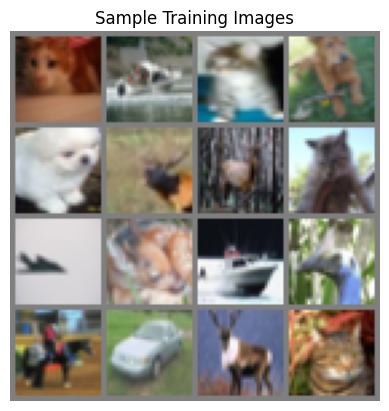

In [ ]:
# Define Model and Training Configuration

config = {
    "patch_size": 4,  # Input image size 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True, # Use the optimized attention implementation
}

# 2. Data Preparation

def prepare_data(batch_size=256):
    """Loads and transforms the CIFAR-10 dataset for ViT."""
    
    # Data augmentation and normalization for training
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((config["image_size"], config["image_size"]), scale=(0.8, 1.0)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Just normalization for validation
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

trainloader, testloader, classes = prepare_data()
print("Data prepared successfully.")
# Let's visualize one batch of images to see what they look like
images, _ = next(iter(trainloader))
img_grid = torchvision.utils.make_grid(images[:16], nrow=4)
plt.imshow(img_grid.permute(1, 2, 0) * 0.5 + 0.5) # Un-normalize
plt.title("Sample Training Images")
plt.axis('off')
plt.show()

In [ ]:
# 3. Training Setup
model = ViTForClassfication(config).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 4. Training and Evaluation Functions
def train_one_epoch(epoch_index):
    model.train()
    running_loss = 0.
    
    # Wrap trainloader with tqdm for a progress bar
    for data in tqdm(trainloader, desc=f"Training Epoch {epoch_index}"):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    return running_loss / len(trainloader)

def evaluate():
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            outputs, _ = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(testloader)
    return accuracy, avg_loss

# 5. Run Training
epochs = 15 # 100+ epochs are needed for good performance
train_losses, test_losses, accuracies = [], [], []

print("Starting training...")
for epoch in range(epochs):
    train_loss = train_one_epoch(epoch + 1)
    accuracy, test_loss = evaluate()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
print("Finished training.")

Number of parameters: 119,098
Starting training...


Training Epoch 1: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s]


Epoch 1/15 - Train Loss: 1.9787, Test Loss: 1.8053, Accuracy: 32.38%


Training Epoch 2: 100%|██████████| 196/196 [00:20<00:00,  9.45it/s]


Epoch 2/15 - Train Loss: 1.7751, Test Loss: 1.6857, Accuracy: 36.75%


Training Epoch 3: 100%|██████████| 196/196 [00:20<00:00,  9.75it/s]


Epoch 3/15 - Train Loss: 1.6920, Test Loss: 1.6398, Accuracy: 38.08%


Training Epoch 4: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]


Epoch 4/15 - Train Loss: 1.6428, Test Loss: 1.6029, Accuracy: 40.13%


Training Epoch 5: 100%|██████████| 196/196 [00:19<00:00,  9.82it/s]


Epoch 5/15 - Train Loss: 1.5749, Test Loss: 1.4862, Accuracy: 44.85%


Training Epoch 6: 100%|██████████| 196/196 [00:19<00:00,  9.96it/s]


Epoch 6/15 - Train Loss: 1.5039, Test Loss: 1.4385, Accuracy: 46.98%


Training Epoch 7: 100%|██████████| 196/196 [00:20<00:00,  9.78it/s]


Epoch 7/15 - Train Loss: 1.4551, Test Loss: 1.4029, Accuracy: 48.41%


Training Epoch 8: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]


Epoch 8/15 - Train Loss: 1.4191, Test Loss: 1.3456, Accuracy: 50.70%


Training Epoch 9: 100%|██████████| 196/196 [00:19<00:00,  9.96it/s]


Epoch 9/15 - Train Loss: 1.3933, Test Loss: 1.3252, Accuracy: 51.28%


Training Epoch 10: 100%|██████████| 196/196 [00:20<00:00,  9.52it/s]


Epoch 10/15 - Train Loss: 1.3666, Test Loss: 1.2945, Accuracy: 53.20%


Training Epoch 11: 100%|██████████| 196/196 [00:21<00:00,  9.16it/s]


Epoch 11/15 - Train Loss: 1.3428, Test Loss: 1.2899, Accuracy: 52.84%


Training Epoch 12: 100%|██████████| 196/196 [00:20<00:00,  9.39it/s]


Epoch 12/15 - Train Loss: 1.3203, Test Loss: 1.2672, Accuracy: 54.29%


Training Epoch 13: 100%|██████████| 196/196 [00:20<00:00,  9.59it/s]


Epoch 13/15 - Train Loss: 1.3036, Test Loss: 1.2696, Accuracy: 54.19%


Training Epoch 14: 100%|██████████| 196/196 [00:19<00:00,  9.88it/s]


Epoch 14/15 - Train Loss: 1.2846, Test Loss: 1.2598, Accuracy: 54.75%


Training Epoch 15: 100%|██████████| 196/196 [00:20<00:00,  9.72it/s]


Epoch 15/15 - Train Loss: 1.2722, Test Loss: 1.2124, Accuracy: 55.58%
Finished training.


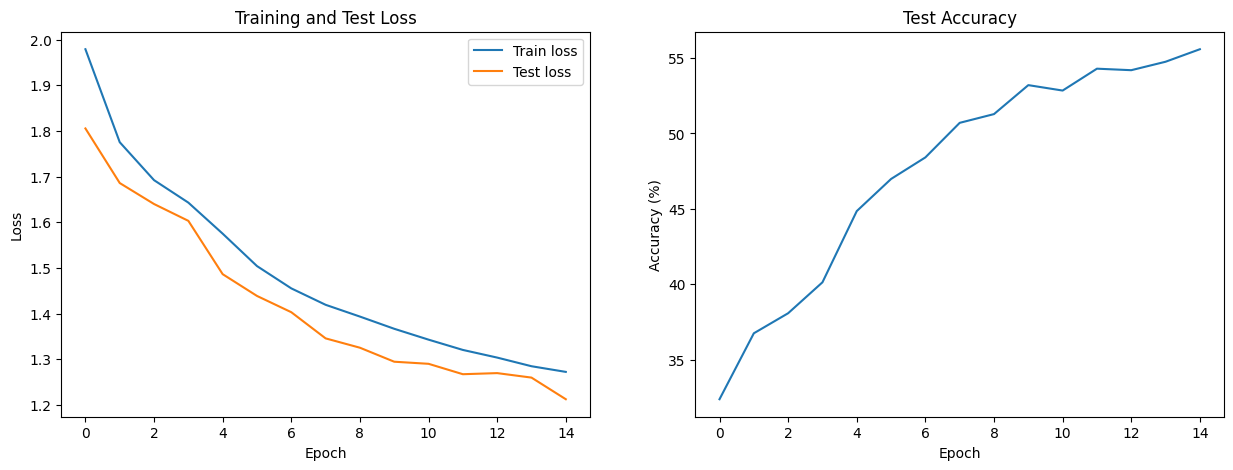


Visualizing model attention...


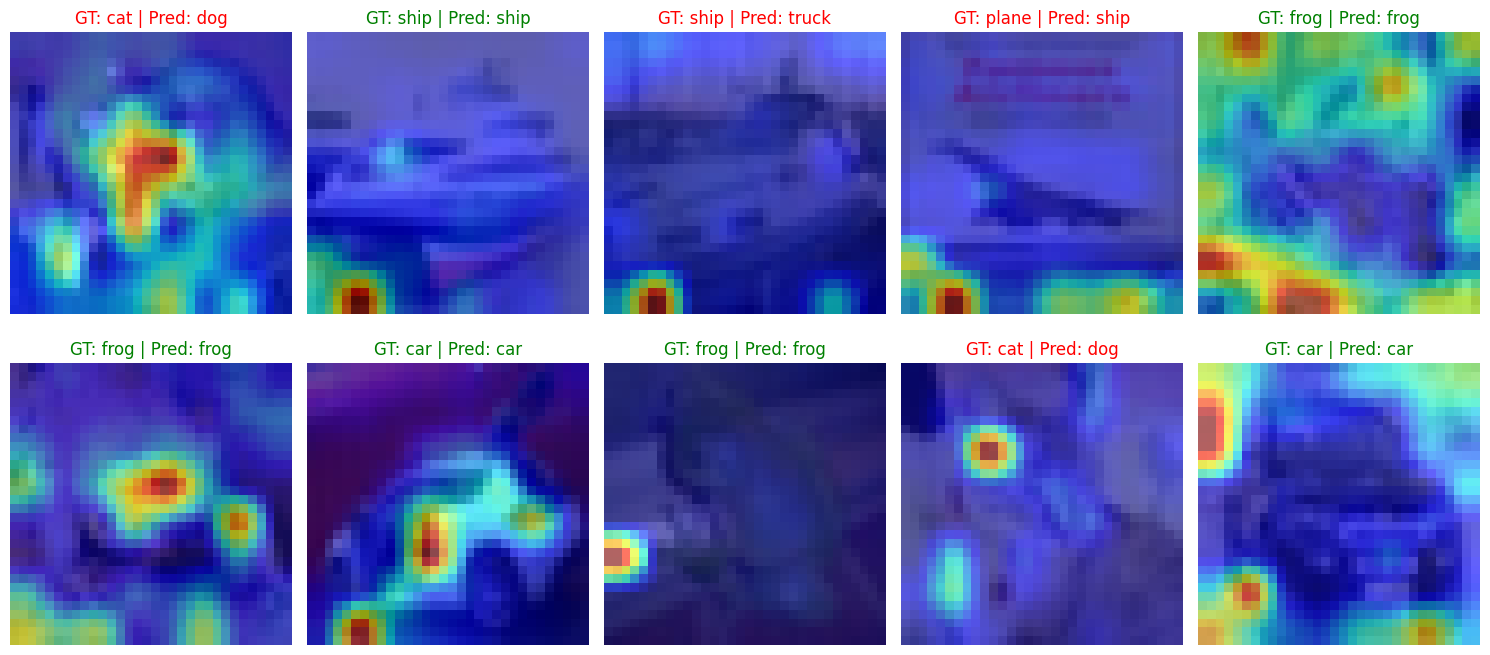

In [ ]:
# 6. Plotting and Visualization

# Plotting Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Training and Test Loss")

ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Test Accuracy")
plt.show()


# Visualizing Attention
@torch.no_grad()
def visualize_attention(model, output_path=None):
    """
    Visualizes the attention from the [CLS] token to the image patches.
    """
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images[:10], labels[:10] # Visualize 10 images

    # Un-normalize for visualization
    raw_images = images * 0.5 + 0.5
    raw_images = raw_images.cpu().numpy()
    
    images_gpu = images.to(device)
    
    # Get attention maps from the last layer
    logits, attention_maps = model(images_gpu, output_attentions=True)
    predictions = torch.argmax(logits, dim=1)
    
    # The output `attention_maps` is a list of attention tensors from each block.
    # We'll visualize the attention from the last block.
    attention_map = attention_maps[-1]
    
    # Average attention across all heads for the [CLS] token
    # Shape: (batch_size, num_heads, seq_len, seq_len)
    # We want the attention from the [CLS] token (index 0) to all other tokens
    cls_attention = attention_map[:, :, 0, 1:].mean(dim=1)
    
    # Reshape to a square grid
    num_patches = cls_attention.size(-1)
    grid_size = int(math.sqrt(num_patches))
    cls_attention = cls_attention.view(-1, grid_size, grid_size)
    
    # Resize the attention map to the original image size for overlay
    resized_attention = nn.functional.interpolate(
        cls_attention.unsqueeze(1),
        size=(config["image_size"], config["image_size"]),
        mode='bilinear', align_corners=False
    ).squeeze(1)

    # Plot the images and their attention maps
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    for i, ax in enumerate(axes.flat):
        img = np.transpose(raw_images[i], (1, 2, 0))
        attn = resized_attention[i].cpu().numpy()
        
        gt = classes[labels[i]]
        pred = classes[predictions[i].cpu()]
        
        ax.imshow(img)
        ax.imshow(attn, alpha=0.6, cmap='jet')
        ax.set_title(f"GT: {gt} | Pred: {pred}", color=("green" if gt == pred else "red"))
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

print("\nVisualizing model attention...")
visualize_attention(model)

## Conclusion

In this notebook, we have successfully implemented a Vision Transformer from its core components using PyTorch. We saw how to:
- Convert an image into a sequence of patch embeddings.
- Add special tokens (`[CLS]`) and positional information.
- Process this sequence using a standard Transformer Encoder.
- Train the model for a classification task.
- Visualize the model's attention to understand its decision-making process.

Even with a small model and very short training, the attention maps begin to highlight the objects of interest within the images. For example, in the images of cars, the attention is focused on the car's body, and for animals, it often highlights the head or main body. This demonstrates the remarkable ability of self-attention to learn spatial features without the inductive biases of convolutions.